# Convolutional Neural Networks

## 9 - Report your Results [25 points]

Report the followings:
 1. The number of parameters in your CNN.
 2. The best accuracy on the testing set (along with the training training set). You will get full credit if your model achieves $ > 70\%$ accuracy on the testing set.
 3. F1 score on the testing set from the model with the best accuracy. There is no provided code for this; please implement F1 score.
 4. A plot containing the **training and testing accuracies** with respect to time (epochs).
 5. A plot containing the **training and testing losses** with respect to time (epochs).
 6. Try 2 more learning rates with the Adam optimizer and report the accuracy and F1 score for both.
 7. Try 2 more optimizers with a fixed learning rate of 0.01 and report the accuracy and F1 score for both.
 8. Trying different learning rates and optimizers is also known as Ablation Study. Organize your results in a table for ease of readability. Please give some insights on the performances of different settings.
 * Finally, please submit the notebook **that contains the output logs**.

 ---

1. The number of parameters in your CNN: 2 060 874

2. The best accuracy on the testing set (along with the training training set). You will get full credit if your model achieves $ > 70\%$ accuracy on the testing set.

My best model was obtained with Adam as optimizer and learning rate 0.001.

Test Accuracy of the model on the 10000 test images: 72.34 % (This calculus was paralelized)

3. F1 score on the testing set from the model with the best accuracy. There is no provided code for this; please implement F1 score.

In [16]:
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 100

cpu


In [18]:
# Data augmentation
transform_train = transforms.Compose([
    ### START CODE HERE ### (≈ 3 lines of code)
    # Fill in data augmentations
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    ### END CODE HERE ###
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Don't augment the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def observe_outputs(self, x): # used to observe the dimension of each layer's output
        x = self.conv1(x)
        print(f'After conv1: {x.size()}')
        x = self.maxpool1(F.relu(x))
        print(f'After maxpool1: {x.size()}')

        x = self.conv2(x)
        print(f'After conv2: {x.size()}')
        x = self.maxpool2(F.relu(x))
        print(f'After maxpool2: {x.size()}')

        x = self.conv3(x)
        print(f'After conv3: {x.size()}')
        x = self.maxpool3(F.relu(x))
        print(f'After maxpool3: {x.size()}')

        x = self.conv4(x)
        print(f'After conv4: {x.size()}')
        x = self.maxpool4(F.relu(x))
        print(f'After maxpool4: {x.size()}')

        # flatten to a vector
        x = x.view(x.size(0), 256)
        print(f'Flatten: {x.size()}')

        x = F.relu(self.fc1(x))
        print(f'After fc1: {x.size()}')
        x = F.relu(self.fc2(x))
        print(f'After fc2: {x.size()}')
        x = self.fc3(x)
        print(f'After fc3: {x.size()}')
        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(F.relu(x))

        x = self.conv2(x)
        x = self.maxpool2(F.relu(x))

        x = self.conv3(x)
        x = self.maxpool3(F.relu(x))

        x = self.conv4(x)
        x = self.maxpool4(F.relu(x))

        # flatten to a vector
        x = x.view(x.size(0), 256)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [25]:
def get_metrics_score_for_pretrained_model(path_to_model):
    model = Model().to(device)
    checkpoint = torch.load(path_to_model, map_location=torch.device('cpu')) # load checkpoint
    model.load_state_dict(checkpoint['net']) # load model parameter

    model.eval()

    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs.to(device))
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions.cpu().numpy() == labels.cpu().numpy()).sum().item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, f1

In [26]:
# Correct usage without modifying the function

accuracy, f1 = get_metrics_score_for_pretrained_model('./checkpoint/ckpt_adam_lr_0.001.pth')
print(f'f1-score: {f1:.4f}')


f1-score: 0.7189


4. A plot containing the **training and testing accuracies** with respect to time (epochs).

In [27]:
# Train the model
def train(epoch, model, criterion, optimizer):
    print('\nEpoch: %d' % epoch)
    train_losses = [] # needed for visualize the traning loss
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)# get a batch
        ### START CODE HERE ### (≈ 5 lines of code)
        # Clear gradient
        optimizer.zero_grad()
        # Forward pass batch through model
        outputs = model(inputs)
        # Calculate loss on batch
        loss = criterion(outputs, targets)
        # Calculate gradients for backward pass
        loss.backward()
        # Update model
        optimizer.step()
        ### END CODE HERE ###

        train_loss += loss.item()
        train_losses.append(loss.item())
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 0: # print every 100 iterations
            print(batch_idx, len(trainloader), 'Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_loss_mean = sum(train_losses)/len(train_losses)
    return train_loss_mean, 100.*correct/total

In [29]:
def test(epoch, model, criterion):
    global best_acc
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            ### START CODE HERE ### (≈ 2 lines of code)
            # Forward pass batch through model
            outputs = model(inputs)
            # Calculate loss on batch
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            test_losses.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 100 == 0:
                print(batch_idx, len(testloader), 'Testing Loss: %.3f | Acc: %.3f%% (%d/%d)'
                            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    test_loss_mean = sum(test_losses)/len(test_losses)
    acc = 100.*correct/total
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))
    if acc > best_acc:
        best_acc = acc
    return test_loss_mean, acc

In [30]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
num_classes = 10 # number of classes
batch_size = 100
num_epochs = 20
learning_rate = 0.001
accuracy_dict = dict()
acc_epochs_train = []
acc_epochs_test = []
loss_epochs_train = []
loss_epochs_test = []
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
best_acc = 0
for epoch in range(start_epoch, start_epoch + num_epochs):
    l_tr, acc_tr = train(epoch, model, criterion, optimizer)
    l_te, acc_te = test(epoch, model, criterion)
    loss_epochs_train.append(l_tr)
    acc_epochs_train.append(acc_tr)
    loss_epochs_test.append(l_te)
    acc_epochs_test.append(acc_te)


Epoch: 0


0 500 Train Loss: 2.302 | Acc: 13.000% (13/100)
100 500 Train Loss: 2.107 | Acc: 19.248% (1944/10100)
200 500 Train Loss: 2.010 | Acc: 23.463% (4716/20100)
300 500 Train Loss: 1.950 | Acc: 26.033% (7836/30100)
400 500 Train Loss: 1.902 | Acc: 28.052% (11249/40100)
0 100 Testing Loss: 1.407 | Acc: 49.000% (49/100)
Test Accuracy of the model on the 10000 test images: 46.07 %

Epoch: 1
0 500 Train Loss: 1.731 | Acc: 39.000% (39/100)
100 500 Train Loss: 1.647 | Acc: 39.050% (3944/10100)
200 500 Train Loss: 1.635 | Acc: 39.498% (7939/20100)
300 500 Train Loss: 1.627 | Acc: 40.076% (12063/30100)
400 500 Train Loss: 1.613 | Acc: 40.973% (16430/40100)
0 100 Testing Loss: 1.190 | Acc: 58.000% (58/100)
Test Accuracy of the model on the 10000 test images: 54.09 %

Epoch: 2
0 500 Train Loss: 1.531 | Acc: 39.000% (39/100)
100 500 Train Loss: 1.516 | Acc: 45.238% (4569/10100)
200 500 Train Loss: 1.516 | Acc: 45.189% (9083/20100)
300 500 Train Loss: 1.504 | Acc: 46.003% (13847/30100)
400 500 Train Lo

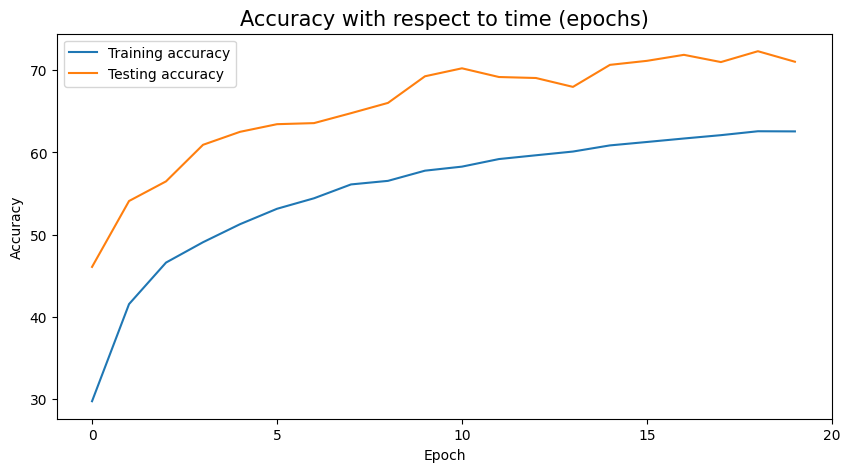

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.title("Accuracy with respect to time (epochs)", fontsize=15)
plt.plot(acc_epochs_train,label="Training accuracy")
plt.plot(acc_epochs_test,label="Testing accuracy")
plt.xticks([0,5,10,15,20])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

5. A plot containing the **training and testing losses** with respect to time (epochs).

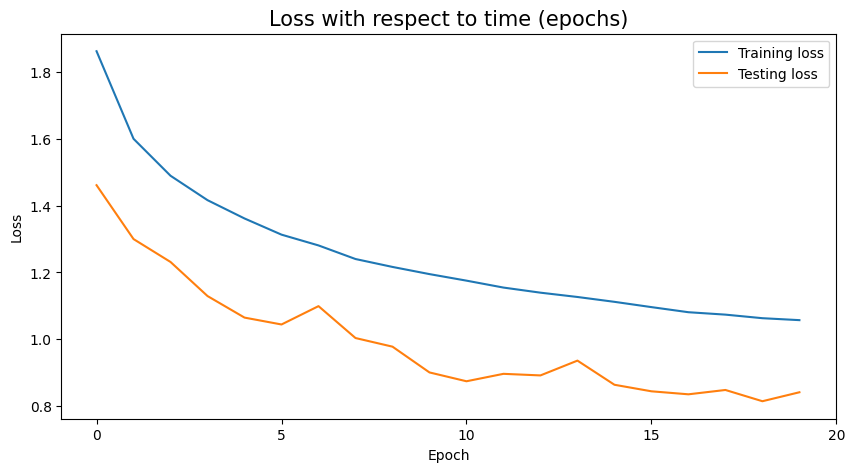

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.title("Loss with respect to time (epochs)", fontsize=15)
plt.plot(loss_epochs_train,label="Training loss")
plt.plot(loss_epochs_test,label="Testing loss")
plt.xticks([0,5,10,15,20])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

6. Try 2 more learning rates with the Adam optimizer and report the accuracy and F1 score for both.

**Note:** I trained the following models in `hw-cnn.ipynb` in "8 - Model Training and Testing", where I defined I double loop to train models for all the possible combinations of optimizers and learning rates I defined in lists. So in here I am loading the pretrained models.

In [33]:
acc, f1 = get_metrics_score_for_pretrained_model('./checkpoint/ckpt_adam_lr_0.01.pth')
print(f'accuracy: {acc*100:.2f}%')
print(f'f1-score: {f1:.4f}')

accuracy: 36.98%
f1-score: 0.3629


In [34]:
acc, f1 = get_metrics_score_for_pretrained_model('./checkpoint/ckpt_adam_lr_0.0001.pth')
print(f'accuracy: {acc*100:.2f}%')
print(f'f1-score: {f1:.4f}')

accuracy: 67.83%
f1-score: 0.6744


7. Try 2 more optimizers with a fixed learning rate of 0.01 and report the accuracy and F1 score for both.

**Note:** I trained the following models in `hw-cnn.ipynb` in "8 - Model Training and Testing", where I defined I double loop to train models for all the possible combinations of optimizers and learning rates I defined in lists. So in here I am loading the pretrained models.

In [35]:
acc, f1 = get_metrics_score_for_pretrained_model('./checkpoint/ckpt_sgd_lr_0.01.pth')
print(f'accuracy: {acc*100:.2f}%')
print(f'f1-score: {f1:.4f}')

accuracy: 52.23%
f1-score: 0.5107


In [36]:
acc, f1 = get_metrics_score_for_pretrained_model('./checkpoint/ckpt_rmsprop_lr_0.01.pth')
print(f'accuracy: {acc*100:.2f}%')
print(f'f1-score: {f1:.4f}')

accuracy: 28.31%
f1-score: 0.2690


8. Trying different learning rates and optimizers is also known as Ablation Study. Organize your results in a table for ease of readability. Please give some insights on the performances of different settings.

**Note:** I trained the following models in `hw-cnn.ipynb` in "8 - Model Training and Testing", where I defined I double loop to train models for all the possible combinations of optimizers and learning rates I defined in lists. So in here I am loading the pretrained models.

In [37]:
learning_rates = [0.01, 0.001, 0.0001] # suggested range [1e-2, 1e-4]
optimizers = ['sgd', 'rmsprop', 'adam']

for optimizer_function in optimizers: # ['sgd', 'rmsprop', 'adam']
    for learning_rate in learning_rates:
        acc, f1 = get_metrics_score_for_pretrained_model(f'./checkpoint/ckpt_{optimizer_function}_lr_{learning_rate}.pth')
        print(f'Optimizer: {optimizer_function} Learning rate: {learning_rate}')
        print(f'\taccuracy: {acc*100:.2f}%')
        print(f'\tf1-score: {f1:.4f}')

Optimizer: sgd Learning rate: 0.01
	accuracy: 52.23%
	f1-score: 0.5107
Optimizer: sgd Learning rate: 0.001
	accuracy: 18.99%
	f1-score: 0.1290
Optimizer: sgd Learning rate: 0.0001
	accuracy: 12.47%
	f1-score: 0.0399
Optimizer: rmsprop Learning rate: 0.01
	accuracy: 28.31%
	f1-score: 0.2690
Optimizer: rmsprop Learning rate: 0.001
	accuracy: 71.47%
	f1-score: 0.7105
Optimizer: rmsprop Learning rate: 0.0001
	accuracy: 66.56%
	f1-score: 0.6616
Optimizer: adam Learning rate: 0.01
	accuracy: 36.98%
	f1-score: 0.3629
Optimizer: adam Learning rate: 0.001
	accuracy: 72.34%
	f1-score: 0.7189
Optimizer: adam Learning rate: 0.0001
	accuracy: 67.83%
	f1-score: 0.6744


| Model | Epochs | Learning rate | Optimizer | Accuracy   | F1-score   |
|-------|--------|---------------|-----------|------------|------------|
| 1     | 20     | 0.01          | SGD       | 52.23%     | 0.5107    |
| 2     | 20     | 0.001         | SGD       | 18.99%     | 0.1290    |
| 3     | 20     | 0.0001        | SGD       | 12.47%    | 0.0399   |
| 4     | 20     | 0.01          | RMSprop   | 28.31%     | 0.2690     |
| _5_   | _20_   | _0.001_       | _RMSprop_ | _71.47%_   | _0.7105_   |
| 6     | 20     | 0.0001        | RMSprop   | 66.56%    | 0.6616   |
| 7     | 20     | 0.01          | Adam      | 36.98%    | 0.3629  |
| **8** | **20** | **0.001**     | **Adam**  | **72.34%** | **0.7189** |
| 9     | 20     | 0.0001        | Adam      | 67.83%    | 0.6744     |

From the ablation study results some insights for the different settings are:
- The best model metrics from all the experiments were obtained when training with the Adam optimizer and the learning rate was 0.001. Accuracy = 72.34%; F1-score: 0.7189
- The best model using the RMSprop optimizer were obtained when defining 0.001 as the learning rate. Accuracy = 71.47%; F1-score: 0.7105
- The best model using the SGD optimizer were obtained when defining 0.01 as the learning rate. Accuracy = 52.23%; F1-score: 0.5107
- In the model obtained when training with the SGD optimizer and the learning rate was 0.0001 (small), the metrics were very poor (accuracy = 12.47%  and f1-score = 0.0399). The reason of this might be that the model should need more epochs to learn with that very small learning rate when working with the SGD optimizer.
- In the model obtained when training with the Adam optimizer and the learning rate was 0.01 (big), the metrics were very poor (accuracy = 36.98%  and f1-score = 0.3629). The reason of this might be that the model is not capable to converge, that means that the model is not capable to find a local minimum.